## 机器学习的基本框架

- Unknown target function $f$: $\mathcal{X} \to \mathcal{Y}$
- Trainning examples $(\mathbf{x}_1, y_1), (\mathbf{x}_2, y_2), \cdots, (\mathbf{x}_N, y_N)$
- Hypothesis set $\mathcal{H}$
- Learning Algorithm $\mathcal{A}$
- Final hypothesis $g$

学习(learning)是利用现有的资料(trainning examples)，通过一些方法步骤(Algorithm)，从我们事先认为有可能的一堆函数(hypothesis set)中找到一个和目标函数$f$“最像”的函数$g$。

下面的五个例子来自于书中的Exercise1.1，让我们来更具体的了解下机器学习的各个组成部分吧！

**Example 1**: Medical diagnosis A patient walks in with a medical history and some symptoms, and you want to identify the problem.

|       输入空间        |输出空间|目标函数|
| :------------------- | :---: | ----: |
| 病人过往病史和当前症状   | 是否患病 | 判别函数 |


**Example 2**: Handwritten digit recognition(for example postal zip code recognition for mail sorting).

|       输入空间        |输出空间|目标函数|
| :------------------- | :---: | ----: |
| 手写数字图片   | 0~9 | 判别函数 |


**Example 3**: Determine if an email is spam or not.

|       输入空间        |输出空间|目标函数|
| :------------------- | :---: | ----: |
| 邮件内容   | 是否为垃圾邮件 | 判断函数 |


**Example 4**: Predicting how an electric load varies with price, temperature, and day of the week.

|       输入空间        |输出空间|目标函数|
| :------------------- | :---: | ----: |
| 电价、气温和日期   | 电量负载 | 预测函数 |


**Example 5**: A problem of interest to you for which there is no analytic solution, but you have data from which to construct an empirical solution.

|       输入空间        |输出空间|目标函数|
| :------------------- | :---: | ----: |
| 现有数据   | 问题的结果 | 经验解决方案 |


## 一个简单的学习模型：感知机

感知机(Perceptron)是最简单的二元线性分类器，如果我们的数据是线性可分的(Linearly separable)，那它一定能在有限步之内找到一条"线"把正负样本分开。感知机学习算法(Perceptron Learning Algorithm)的主要精神是“**知错能改**”：在每一轮迭代中，它会先找到一个错分点，然后对其进行修正，尽可能弥补之前的过错。当然，由于一次只关心这一个点，可能这次更新后其他点的情况变得糟糕了，但是感知机会说：“别担心，我们接下来会改的！”

### 无噪音数据

In [40]:
import numpy as np
import matplotlib.pyplot as plt

首先，我们假设目标函数 $f$ 为线性函数$f(\mathbf{x})=\mathbf{w}^T\mathbf{x} $，其中 $\mathbf{w}=(-1, 2, -1)^T$, $\mathbf{x}=(x_0, x_1, x_2)^T.$

In [41]:
# Target function: -1 + 2x1 - x2
w = np.array([-1, 2, -1])

接着，从 $d$ 维立方体 $[-5, 5]^d$中随机生成样本大小为$N$的模拟数据，这里假设 $d=2$，$N=20$. 利用目标函数将数据打上标签（+1或-1)，也就是说数据本身是线性可分的，因此PLA一定会收敛。

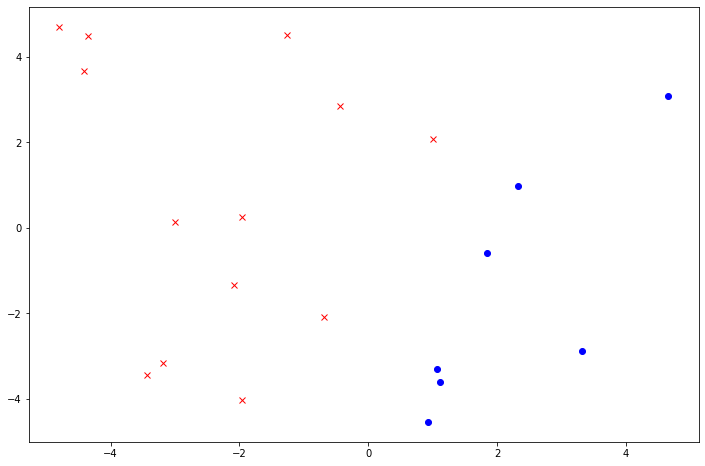

In [42]:
N, d = 20, 2 # Sample size, number of features

def generateXY(N, d, w):
    """
    Generate a random sample X of size N from a d-dimensional uniform distribution: [-5, 5]^d.
    Label each point by the target linear function described by weight vector w.
    
    Args:
        N: int, sample size
        d: int, number of features
        w: ndarray of shape = [d + 1, ], weight of the target linear function including bias w0
        
    Returns:
        X: ndarray of shape = [N, d], feature matrix
        y: ndarray of shape = [N, ], labels
    """
    X = np.random.uniform(-5, 5, (N, d))
    X_ones = np.c_[np.ones((N, 1)), X]
    y = 2 * (X_ones @ w > 0) - 1  # y = +1 or -1
    return X, y

# Set a random seed to get a persistent answer
np.random.seed(42)

# Generate data
X, y = generateXY(N, d, w)

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(X[y==1][:, 0], X[y==1][:, 1], color='blue', marker='o', linestyle='None', label='+1')
ax.plot(X[y==-1][:, 0], X[y==-1][:, 1], color='red', marker='x', linestyle='None', label='-1');

接下来实现PLA算法，共两个版本：
1. 按照样本原有顺序依次取点，循环直至没有错误为止（`PLA_cyclic`）；
2. 随机打乱原有样本顺序后再送入版本1 （`random_cycle=True`）。

In [43]:
def PLA(X, y, random_cycle=False):
    """
    PLA by visiting examples in the naive cycle using the order of examples in the data set (X, y)
    or through a pre-determined random cycle.
    
    Args:
        X: ndarray of shape = [N, d], feature matrix
        y: ndarray of shape = [N, ], labels
        random_cycle: boolean, whether to use random cycle ordering
        
    Returns:
        w: ndarray of shape = [d + 1, ], final weights including bias w0
        update_cnt: int, the total number of updates to get all points classified correctly
    """
    
    N = X.shape[0]
    
    if random_cycle:
        indices = np.arange(N)
        np.random.shuffle(indices)  
        X = X[indices]
        y = y[indices]
        
    w, update_cnt = PLA_cyclic(X, y)
    
    return w, update_cnt
        

def PLA_cyclic(X, y):
    """
    PLA by visiting examples in the naive cycle using the order of examples in the data set (X, y).
    
    Args:
        X: ndarray of shape = [N, d], feature matrix
        y: ndarray of shape = [N, ], labels
        
    Returns:
        w: ndarray of shape = [d + 1, ], final weights including bias w0
        update_cnt: int, the total number of updates to get all points classified correctly
    """
    
    N, d = X.shape
    X = np.c_[np.ones((N, 1)), X]
    w = np.zeros(d + 1)
    
    # Count the number of updates
    update_cnt = 0 
    
    is_finished = 0
    correct_num = 0
    t = 0

    while not is_finished:
        x_t, y_t = X[t], y[t]
        
        if sign(w.T @ x_t) == y_t:  # Correctly classify the current example
            correct_num += 1
        else:                       # Find a mistake
            w += y_t * x_t          # Correct the mistake
            update_cnt += 1         # Increment update count
            correct_num = 0         # Reset correct num to 0 to retest the new w
        if t == N - 1:              # Start the next cycle
            t = 0
        else:
            t += 1
        if correct_num == N:        # Have all examples classified correctly
            is_finished = 1
  
    return w, update_cnt    

######## Some helper functions ########
def sign(x):
    return 1 if x > 0 else -1

看一下实际效果如何：

In [44]:
w_pla, update_cnt = PLA(X, y, random_cycle=True)
print(f"w_pla={w_pla}, update_cnt={update_cnt}")

w_pla=[-3.          3.13801068 -2.1162567 ], update_cnt=5


可以看到只经过5步PLA算法就收敛了，主要原因是这里的样本点本身比较少并且权重$\mathbf{w}$的初始值$\mathbf{0}$已经能将大部分点分开了。我们把这根线画到图上：

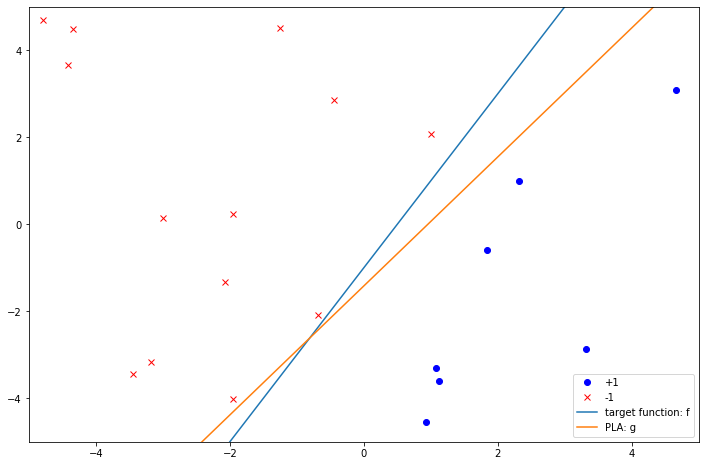

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(X[y==1][:, 0], X[y==1][:, 1], color='blue', marker='o', linestyle='None', label='+1')
ax.plot(X[y==-1][:, 0], X[y==-1][:, 1], color='red', marker='x', linestyle='None', label='-1')

xs = np.arange(-5, 5, 0.1) # Generate plot data

ax.plot(xs, [-(w[0] + w[1] * x)/w[2] for x in xs], label='target function: f')
ax.plot(xs, [-(w_pla[0] + w_pla[1] * x)/w_pla[2] for x in xs], label='PLA: g')
ax.set_xlim(left=-5, right=5)
ax.set_ylim(bottom=-5, top=5)
ax.legend();


最后我们试着和`sklearn`中的PLA比较一下结果。

In [47]:
from sklearn.linear_model import Perceptron

In [48]:
clf = Perceptron(tol=1e-3)
clf.fit(X, y)

clf.score(X, y)  # Returns the mean accuracy on the given test data and labels.
                 # Here 1.0 means there is no error on the training set 

1.0

这里返回的`score`值为1.0， 说明感知机把我们的数据完全分开了，没有任何错误。

In [49]:
clf.intercept_, clf.coef_

(array([-3.]), array([[ 5.98783968, -1.78432935]]))

weight $\mathbf{w}$的值为$(-3, 5.98783968, -1.78432935)^T$.

我们把`sklearn`得到的线也画出来：

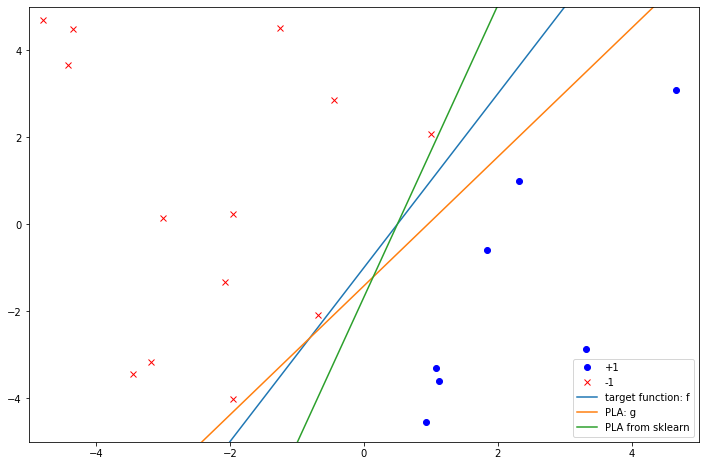

In [50]:
# Combine the intercept and coefficients 
w_skl = np.r_[clf.intercept_, clf.coef_.flatten()]

# Add the PLA result from sklearn
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(X[y==1][:, 0], X[y==1][:, 1], color='blue', marker='o', linestyle='None', label='+1')
ax.plot(X[y==-1][:, 0], X[y==-1][:, 1], color='red', marker='x', linestyle='None', label='-1')

xs = np.arange(-5, 5, 0.1)

ax.plot(xs, [-(w[0] + w[1] * x)/w[2] for x in xs], label='target function: f')
ax.plot(xs, [-(w_pla[0] + w_pla[1] * x)/w_pla[2] for x in xs], label='PLA: g')
ax.plot(xs, [-(w_skl[0] + w_skl[1] * x)/w_skl[2] for x in xs], label='PLA from sklearn')

ax.set_xlim(left=-5, right=5)
ax.set_ylim(bottom=-5, top=5)
ax.legend();


可以看到，不管是我们自己写的PLA，还是利用`sklearn`得到的感知机，都能完美地分割这组数据，但是它们又都不是目标函数本身。

### 针对有噪音数据：Pocket算法

上面生成的模拟数据是不带噪音的，而如果我们考虑噪音的影响，也就是说$f$得到$y$后又有一定概率$y$的符号会发生改变，那这时该怎么找函数$g$呢？

我们先看看带有噪音的数据是怎么样的（假设 $y$ 的符号翻转概率为$p=0.2$）。

In [51]:
def generateXY_with_noise(N, d, w, p):
    """
    Generate a random sample X of size N from a d-dimensional uniform distribution: [-5, 5]^d.
    Label each point by the target linear function described by weight vector w first 
    and then flip the result with probability p.
    
    Args:
        N: int, sample size
        d: int, number of features
        w: ndarray of shape = [d + 1, ], weight of the target linear function including bias w0
        p: float, the probablity of y that will flip
        
   Returns:
        X: ndarray of shape = [N, d], feature matrix
        y: ndarray of shape = [N, ], labels        
    """
    X = np.random.uniform(-5, 5, (N, d))
    X_ones = np.c_[np.ones((N, 1)), X]
    
    # Label each point by target function
    y = 2 * (X_ones @ w > 0) - 1  # y = +1 or -1
    
    # Flip the label y with probability p
    for i in range(N):
        rand_num = np.random.rand()
        if rand_num < p:
            y[i] = -y[i]
            
    return X, y

In [52]:
p = 0.2 # Probability that y will flip

# Set a random seed to get a persistent answer
np.random.seed(42)

X_noisy, y_noisy = generateXY_with_noise(N, d, w, p)

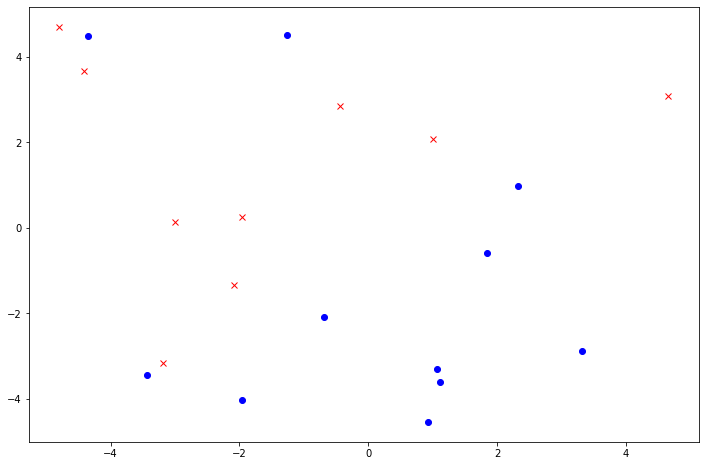

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(X_noisy[y_noisy==1][:, 0], X_noisy[y_noisy==1][:, 1], color='blue', marker='o', linestyle='None', label='+1')
ax.plot(X_noisy[y_noisy==-1][:, 0], X_noisy[y_noisy==-1][:, 1], color='red', marker='x', linestyle='None', label='-1'); 

可以看到这个时候的数据不是线性可分的，因此PLA不收敛。那可不可以修改一下PLA得到一个“还不错”的 $g$ 呢？这就要提到Pocket算法了。

Pocket算法是一种贪心算法，它比普通的PLA的多了一个变量和一个步骤：
- 一个变量：用来记录手头上已有的最好的权重$\mathbf{w}_{\text{pocket}}$；
- 一个步骤：权重每次更新后需要计算新的错误率并和已有的进行比较，如果新的错误率更低，就用这个新的权重替代已有的$\mathbf{w}_{\text{pocket}}$.

正是因为多出来的这一步，使得Pocket算法在速度上会比普通的PLA慢一些。下面是Pocket算法的实现：

In [54]:
def PLA_pocket(X, y, num_update=50):
    """
    Modified PLA algorithm by keeping best weights in pocket.
    
    Args:
        X: ndarray of shape = [n, d], feature matrix
        y: ndarray of shape = [n, ], labels
        num_update: int, default=50, number of updates for w_pocket to run on the data set
    
    Returns:
        w_pocket: ndarray of shape = [d + 1, ], best weights including bias w0
    """
    
    n, d = X.shape
    # Add a column of ones as first column
    X = np.c_[np.ones((n, 1)), X]
    
    # Initialize w to 0 and add an extra zero for w0
    w = np.zeros(d + 1)
    w_pocket = np.zeros(d + 1)
    
    smallest_error_rate = 1.0
    update_cnt = 0
    t = 0
    correct_num = 0
    
    while update_cnt < num_update and correct_num < n:
        x_t, y_t = X[t], y[t]
        if sign(w.T @ x_t) == y_t:
            correct_num += 1
        else:
            w += y_t * x_t
            update_cnt += 1
            correct_num = 0
            current_error_rate = error_rate(X, y, w)
            if current_error_rate < smallest_error_rate:
                w_pocket = w.copy()  #### NOTE: DO NOT write w_pocket=w directly, otherwise, w_pocket and w will point to the same object
                smallest_error_rate = current_error_rate
        if t == n - 1:
            t = 0
        else:
            t += 1   
            
    return w_pocket

################ Helper functions ################

# Vectorized version of sign function
sign_vec = np.vectorize(sign)


def error_rate(X, y, w):
    """
    Calculate the current error rate with the given weights w and examples (X, y).
    
    Returns:
        err: float, error rate 
    Argss
        X: ndarray of shape = [n, d + 1], feature matrix including a column of ones as first column
        y: ndarray of shape = [n, ], labels
        w: ndarray of shape = [d + 1, ], current weight
    """
    
    n = y.shape[0]
    err = np.sum(sign_vec(X @ w) != y) / n
    
    return err

将Pocket算法应用到带有噪音的数据上后：

In [55]:
w_pocket = PLA_pocket(X_noisy, y_noisy, num_update=100)
w_pocket

array([ 2.        ,  1.80158115, -3.38519667])

错误率为：

In [56]:
error_rate(np.c_[np.ones((N, 1)), X_noisy], y_noisy, w_pocket)

0.2

可以看到错误率为0.2，也就是20个点中有4个点错分了。考虑到$y$的符号翻转概率为0.2，因此20个点中平均会有4个点受到噪音的干扰。从这一点上来说，利用Pocket算法所获得的简单线性分类器，它在非线性可分的数据集上出错的平均个数也应该在4个左右，这和实际结果也是相符的。

将这个新的线性分类器作图如下：

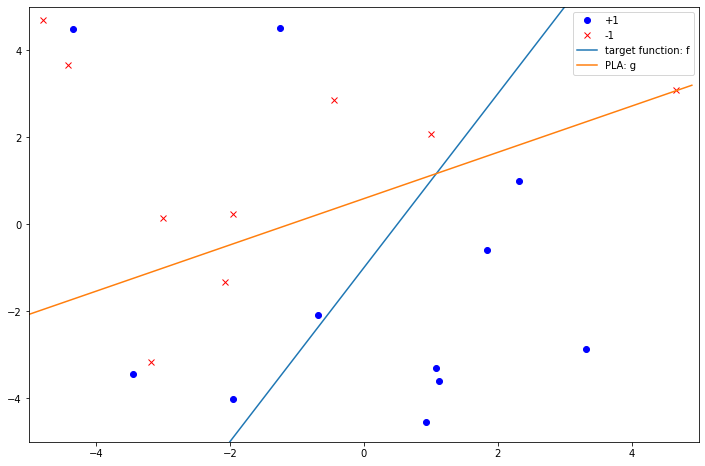

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(X_noisy[y_noisy==1][:, 0], X_noisy[y_noisy==1][:, 1], color='blue', marker='o', linestyle='None', label='+1')
ax.plot(X_noisy[y_noisy==-1][:, 0], X_noisy[y_noisy==-1][:, 1], color='red', marker='x', linestyle='None', label='-1')

xs = np.arange(-5, 5, 0.1) # Generate plot data

ax.plot(xs, [-(w[0] + w[1] * x)/w[2] for x in xs], label='target function: f')
ax.plot(xs, [-(w_pocket[0] + w_pocket[1] * x)/w_pocket[2] for x in xs], label='PLA: g')
ax.set_xlim(left=-5, right=5)
ax.set_ylim(bottom=-5, top=5)

ax.legend();

为了凸显出分类边界（也就是$g$），我们加入背景色（实际上是利用$g$对整个二维平面进行分类，得到密密麻麻的点）：用浅蓝色代表+1的区域，粉色代表-1的区域，结果如下：

In [58]:
x1_np = np.linspace(-5, 5, 100)
x2_np = np.linspace(-5, 5, 100)

blue_range = []
red_range = []

g = lambda x: sign(w_pocket @ x)

for i in range(len(x1_np)):
    for j in range(len(x2_np)):
        x = [x1_np[i], x2_np[j]]
        x_ext = np.r_[1, x]
        if g(x_ext) > 0:
            blue_range.append(x)
        else:
            red_range.append(x)
            
blue_range_np = np.array(blue_range)
red_range_np = np.array(red_range)


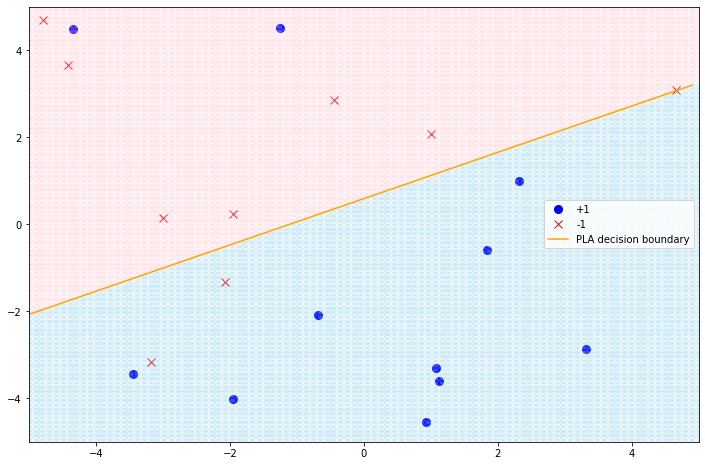

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(X_noisy[y_noisy==1][:, 0], X_noisy[y_noisy==1][:, 1], color='blue', marker='o', markersize=8, linestyle='None', label='+1')
ax.plot(X_noisy[y_noisy==-1][:, 0], X_noisy[y_noisy==-1][:, 1], color='red', marker='x', markersize=8, linestyle='None', label='-1')

ax.plot(red_range_np[:, 0], red_range_np[:, 1], color='pink', marker='o', linestyle='None', alpha=0.2)
ax.plot(blue_range_np[:, 0], blue_range_np[:, 1], color='skyblue', marker='o', linestyle='None', alpha=0.2)

xs = np.arange(-5, 5, 0.1) 
# ax.plot(xs, [-(w[0] + w[1] * x)/w[2] for x in xs], label='target function: f')
ax.plot(xs, [-(w_pocket[0] + w_pocket[1] * x)/w_pocket[2] for x in xs], color='orange', label='PLA decision boundary')

ax.set_xlim(left=-5, right=5)
ax.set_ylim(bottom=-5, top=5)
ax.legend();

加上“背景色”后，我们就可以清楚地看到分类边界和错分点了。